In [1]:
from quantipy.assets import Currency, Equity
from quantipy.trading import Position

# Creating a currency object
usd = Currency('USD')
print('Currency: ', usd.currency)
print('Is cash?: ', usd.is_cash)

print('\n')

# Creating an Equity object
aapl = Equity(name='Apple', symbol='AAPL')
print('Stock name: ', aapl.name)
print('Symbol: ', aapl.symbol)
print('Is cash?: ', aapl.is_cash)

# Creating positions
eur = Currency('EUR')
cash_position = Position(eur, 10_000)
boeing = Equity('Boeing', 'BA')
boeing_position = Position(boeing, 10_000)

Currency:  USD
Is cash?:  True


Stock name:  Apple
Symbol:  AAPL
Is cash?:  False


In [2]:
from quantipy.trading import Order, Trade, Broker
import yfinance as yf

ba = yf.ticker.Ticker('BA')
data1 = ba.history(start='2024-01-15', end='2024-03-01', interval='1h')
aapl = yf.ticker.Ticker('AAPL')
data2 = aapl.history()
data = {'BA':data1, 'AAPL':data2}

In [3]:
# Creating our broker with 10k euros initial capital
my_broker = Broker(data=data, initial_capital=10_000, currency=eur)

# Creating a new order for half of our equity on Boeing
my_broker._new_order(boeing, 0.5)
print('Outstanding orders: ', my_broker.orders)
my_broker._process_orders()

Outstanding orders:  [<quantipy.trading.Order object at 0x7f4c579a8190>]


In [4]:
print('Outstanding orders: ', my_broker.orders)
print('Open trades: ', my_broker.trades)
print('Open positions: ', my_broker.positions)

Outstanding orders:  []
Open trades:  [<quantipy.trading.Trade object at 0x7f4c0432a990>]
Open positions:  []


In [5]:
current_trade = my_broker.trades[0]

my_broker._new_order(boeing, -15, parent_trade=current_trade)
my_broker.orders

my_broker._process_orders()

In [6]:
current_trade.size

9.0

In [7]:
my_broker.orders
my_broker._new_order(boeing, -14, parent_trade=current_trade)


In [8]:
my_broker._process_orders()

my_broker.trades
my_broker.closed_trades

In [9]:
from quantipy.trading import Strategy
from quantipy.backtest import Backtester

class TestStrategy(Strategy):
    def __init__(self, broker, asset, tp=210, sl=200, stop=205):
        super().__init__(broker)
        self.__asset = asset
        self.__tp = tp
        self.__sl = sl
        self.__stop = stop
        self.__limit = stop
    
    @property
    def asset(self):
        return self.__asset 
    
    def next(self):
        if self._Strategy__broker.orders == []:
            self.buy(self.__asset,
                     stop=self.__stop,
                     limit=self.__limit,
                     stop_loss=self.__sl,
                     take_profit=self.__tp)
            self.broker.logger.debug('order set')

my_broker = Broker(data=data, initial_capital=10_000, currency=eur)
strategy = TestStrategy(my_broker, boeing)

backtester = Backtester(data)
results = backtester.run(strategy, save_logs=True)

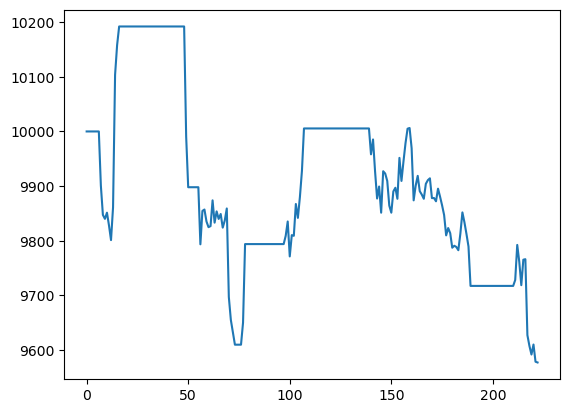

In [10]:
import matplotlib.pyplot as plt
plt.plot(results['Equity'])

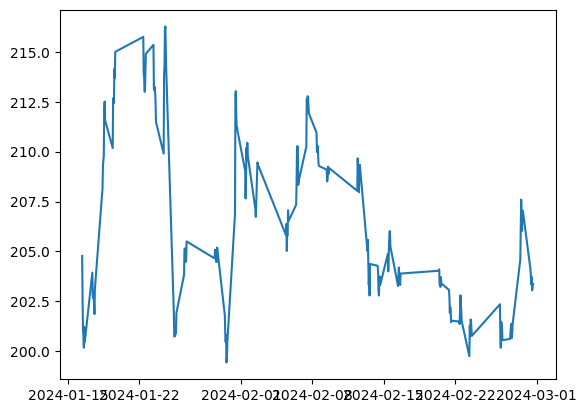

In [11]:
plt.plot(data['BA'].Close)

In [12]:
my_broker.closed_trades

In [13]:
results['Data']

{'BA':                                  Open        High         Low       Close  \
 Datetime                                                                    
 2024-01-16 09:30:00-05:00  210.500000  210.940201  204.259995  204.775894   
 2024-01-16 10:30:00-05:00  204.809906  204.809906  201.100006  202.604996   
 2024-01-16 11:30:00-05:00  202.619995  203.625000  200.559998  201.100006   
 2024-01-16 12:30:00-05:00  201.084793  201.559998  200.091003  200.759995   
 2024-01-16 13:30:00-05:00  200.768204  200.860001  199.500000  200.175003   
 ...                               ...         ...         ...         ...   
 2024-02-29 10:30:00-05:00  204.119995  204.300003  203.033997  203.664993   
 2024-02-29 11:30:00-05:00  203.679993  203.679993  202.820007  203.330002   
 2024-02-29 12:30:00-05:00  203.369995  204.039902  203.000000  203.718399   
 2024-02-29 13:30:00-05:00  203.729996  203.744995  202.899994  203.050598   
 2024-02-29 14:30:00-05:00  203.020401  203.499496  202.70